In [1]:
import pandas as pd, numpy as np
import pickle
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [63]:
# Load dataset
ml_dataset_path = '../data/dataset_multilabel.pkl'
with open(ml_dataset_path, 'rb') as file:
    dataset = pickle.load(file) 
    X = dataset.drop(columns=['expert_PAM50_subtype', 'tcga_id',
                    'Subtype-from Parker centroids', 'MaxCorr',
                        'Basal', 'Her2', 'LumA', 'LumB', 'Normal'], inplace=False)
    y = dataset['Subtype-from Parker centroids']

In [64]:
from data_preprocessing import remove_extreme
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from utils import log_transform

# Remove extreme values (genes, samples) from initial preprocessing
X, potential_samples_to_remove, \
    feat_to_remove, feat_to_keep = remove_extreme(X, change_X = True)

# Split the dataset
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                    random_state=1, shuffle=True, stratify=y)  

# Encode the class labels
LB = LabelEncoder() 
y_train = pd.Series(LB.fit_transform(y_train), index=y_train.index)
y_test = LB.transform(y_test)

# Data standardization | normalization
X_train = X_train.divide(X_train.sum(axis=1), axis=0) * 1e6
X_test = X_test.divide(X_test.sum(axis=1), axis=0) * 1e6
scaler = FunctionTransformer(log_transform)
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)


There are 0 columns with more than 80% of Null values!
There are 22722 columns with more than 20% of count values greater than 4!


In [100]:
remove_corr_feat = False

# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

if remove_corr_feat:
    corr_features = correlation(X_train_scaled, 0.8)
    print('correlated features: ', len(set(corr_features)) )

    with open('../data/correlated_features_08.pkl', 'wb') as file:
        pickle.dump(list(set(corr_features)), file)
else:
    with open('../data/correlated_features_08.pkl', 'rb') as file:
        corr_features = pickle.load(file)

# Remove correlated features
X_train_scaled = X_train_scaled.drop(columns=corr_features)
X_train_scaled

In [68]:
from sklearn.feature_selection import SelectKBest, f_classif

# Initialize SelectKBest with the desired number of features and ANOVA F-test
num_features_to_select = 1000
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)

# Fit and transform the selector on the data
X_selected = selector.fit_transform(X_train_scaled, y_train)

# Get selected feature indices
selected_feature_indices = selector.get_support(indices=True)
X_train_selected_kbest = X_train_scaled.loc[:, X_train_scaled.columns[selected_feature_indices]]
X_train_selected_kbest

,A2ML1,ABAT,ABCA13,ABCC11,ABCC8,ABCG1,ABLIM3,ABRACL,ABTB2,ACADSB,...,ZNF442,ZNF454,ZNF462,ZNF467,ZNF552,ZNF670-ZNF695,ZNF703,ZNF763,ZNF844,ZNF91
225,-2.050456,6.235758,-2.096476,2.089319,3.980527,6.596542,4.995204,4.648930,4.251042,5.376071,...,1.836639,-0.629313,4.391634,5.229189,6.814213,1.499188,8.024337,2.354478,5.061769,5.327919
598,-0.982464,5.620867,-2.997826,7.707925,4.942180,6.252514,6.302771,5.232328,2.449090,7.186747,...,1.925957,-0.538480,5.152345,4.787756,3.240962,-1.177447,7.166321,1.485231,2.345877,5.127694
405,-1.173796,6.408448,-2.030408,4.434958,2.043535,4.498333,4.430176,3.253433,0.233094,7.409356,...,2.639409,-0.743737,2.350015,0.567388,6.617840,0.317623,3.042350,1.522554,5.089835,7.244646
265,5.918910,2.483358,-1.928260,-0.040500,-2.771039,4.176150,2.041034,6.591590,2.025465,3.629003,...,0.172393,0.584815,5.108070,2.749217,2.976227,2.984769,4.707676,1.784751,3.536584,4.375048
955,0.811845,3.572643,-3.304834,4.012581,3.368940,6.179781,3.588720,5.309308,2.949395,5.959206,...,2.299435,-1.514697,3.088915,5.740348,4.443134,-1.728427,6.462758,1.011239,4.056546,4.993604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,-2.873832,6.699458,-2.371754,8.323628,2.136522,6.571472,5.459071,5.032675,1.826570,8.808552,...,1.448432,0.102580,3.169815,3.267384,7.136506,-0.322813,7.423128,2.309464,4.380126,6.339697
765,-2.262172,6.738774,-2.819798,5.421944,2.371607,2.317463,5.931625,5.717693,3.460396,6.135081,...,2.370935,-2.415625,0.523490,3.995264,5.715511,1.385551,7.984382,2.548009,5.472499,5.821836
137,-0.456085,4.622806,-0.191239,3.681104,5.222662,5.206322,5.039976,5.418430,2.589833,4.997043,...,1.672119,-0.201089,4.868910,4.082683,4.967788,0.663333,7.427151,2.100207,4.600968,4.478232
244,5.123030,3.660404,0.089408,0.792025,-2.976719,5.831240,4.731199,5.376901,3.609198,4.621584,...,2.101116,1.094685,4.413322,2.565383,3.006979,1.629583,3.689363,1.767233,4.289107,4.303812


In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

min_features_to_select = 400  # Minimum number of features to consider
for i in range(6, 13):
    clf = RandomForestClassifier(n_estimators=100, random_state=i)
    cv = StratifiedKFold(5)

    rfecv = RFECV(
        estimator=clf,
        step=1,
        cv=cv,
        scoring="accuracy",
        min_features_to_select=min_features_to_select,
        n_jobs=2,
        verbose=2
    )
    rfecv.fit(X_train_selected_kbest, y_train)

    feat_fr_rfecv = X_train_selected_kbest.loc[:, rfecv.support_].columns
    num_feat_selected = len(feat_fr_rfecv)

    with open('../data/feature_selection_{}_randomstate_{}.pkl'.format(num_feat_selected, i), 'wb') as file:
        pickle.dump(feat_fr_rfecv, file)


In [77]:
feat_fr_rfecv = X_train_selected_kbest.loc[:, rfecv.support_].columns
len(feat_fr_rfecv)

657

In [79]:
with open('../data/feature_selection_{}_randomstate_{}.pkl'.format(0, 0), 'wb') as file:
        pickle.dump(feat_fr_rfecv, file)

In [90]:
import os
from re import search

dict_of_feat = {}
for i in range(4, 14):
    files = os.listdir('../data')
    search_string = 'randomstate_' + str(i)
    file_to_find = [filename for filename in files if filename.__contains__(search_string)]
    path = '../data/'+file_to_find[0]
    with open(path, 'rb') as file:
        list_of_features = pickle.load(file)
        for feature in list_of_features:
            if feature not in dict_of_feat:
                dict_of_feat[feature]=0
            dict_of_feat[feature] += 1

dict_of_feat

{'A2ML1': 8,
 'ABAT': 8,
 'ABCA13': 4,
 'ABCC11': 10,
 'ABCC8': 9,
 'ABCG1': 1,
 'ACADSB': 10,
 'ACBD4': 10,
 'ACE2': 10,
 'ACOT4': 6,
 'ACOX2': 10,
 'ACTR3B': 3,
 'ADCY9': 10,
 'ADIRF': 6,
 'AFF3': 10,
 'AGR2': 10,
 'AK8': 9,
 'AKR1E2': 3,
 'AKR7A3': 6,
 'ALDH6A1': 6,
 'ANKMY1': 5,
 'ANKRA2': 3,
 'ANKRD30A': 10,
 'ANKRD42': 4,
 'ANLN': 10,
 'ANP32E': 10,
 'ANXA8': 10,
 'ANXA9': 10,
 'APBA2': 6,
 'APBB2': 9,
 'APH1B': 10,
 'AR': 10,
 'ARFGEF3': 5,
 'ARHGEF38': 10,
 'ARMT1': 10,
 'ARSG': 10,
 'ART3': 8,
 'ATL2': 8,
 'ATP6AP1L': 1,
 'ATP7B': 2,
 'AURKA': 10,
 'B3GNT5': 10,
 'BBOF1': 10,
 'BBOX1': 10,
 'BBS1': 9,
 'BCAM': 8,
 'BCAS1': 10,
 'BCL11A': 10,
 'BCL2': 10,
 'BECN1': 7,
 'BLM': 10,
 'BTG2': 10,
 'C10orf90': 10,
 'C11orf91': 8,
 'C1orf106': 4,
 'C1orf168': 2,
 'C1orf21': 9,
 'C1orf64': 10,
 'C1QL2': 4,
 'C1QL4': 9,
 'C22orf23': 9,
 'C2orf71': 9,
 'C3orf18': 8,
 'C5orf30': 3,
 'C5orf49': 1,
 'C6orf15': 10,
 'C9orf152': 10,
 'C9orf40': 1,
 'C9orf64': 7,
 'CA12': 10,
 'CA6': 3,
 'CA9

In [93]:
sorted_dict = {k: v for k, v in sorted(dict_of_feat.items(), key=lambda item: item[1], reverse=True)}
sorted_dict

{'ABCC11': 10,
 'ACADSB': 10,
 'ACBD4': 10,
 'ACE2': 10,
 'ACOX2': 10,
 'ADCY9': 10,
 'AFF3': 10,
 'AGR2': 10,
 'ANKRD30A': 10,
 'ANLN': 10,
 'ANP32E': 10,
 'ANXA8': 10,
 'ANXA9': 10,
 'APH1B': 10,
 'AR': 10,
 'ARHGEF38': 10,
 'ARMT1': 10,
 'ARSG': 10,
 'AURKA': 10,
 'B3GNT5': 10,
 'BBOF1': 10,
 'BBOX1': 10,
 'BCAS1': 10,
 'BCL11A': 10,
 'BCL2': 10,
 'BLM': 10,
 'BTG2': 10,
 'C10orf90': 10,
 'C1orf64': 10,
 'C6orf15': 10,
 'C9orf152': 10,
 'CA12': 10,
 'CACNA2D2': 10,
 'CCNE1': 10,
 'CCNE2': 10,
 'CDC25B': 10,
 'CDC7': 10,
 'CDCA7': 10,
 'CENPN': 10,
 'CENPW': 10,
 'CHEK1': 10,
 'CHST2': 10,
 'CHST3': 10,
 'CIB3': 10,
 'CKS1B': 10,
 'CMBL': 10,
 'CNTNAP3': 10,
 'CPLX1': 10,
 'CRYAB': 10,
 'CT62': 10,
 'CTPS1': 10,
 'CX3CL1': 10,
 'CXCL1': 10,
 'CXXC5': 10,
 'DBF4': 10,
 'DEGS2': 10,
 'DMD': 10,
 'DNMT3B': 10,
 'DSCC1': 10,
 'DUSP7': 10,
 'EGFR': 10,
 'EPHB6': 10,
 'ERBB2': 10,
 'ERBB3': 10,
 'ERBB4': 10,
 'EZH2': 10,
 'FABP7': 10,
 'FAM120AOS': 10,
 'FAM134C': 10,
 'FAM171A1': 10,
 'FA

In [98]:
# Value to be removed
value_to_remove = 1

# Create a new dictionary without keys that have the given value
sorted_dict = {key: value for key, value in sorted_dict.items() if value != value_to_remove}

In [101]:
# Value to be removed
value_to_remove = 2

# Create a new dictionary without keys that have the given value
sorted_dict = {key: value for key, value in sorted_dict.items() if value != value_to_remove}

len(sorted_dict)

655

In [102]:
# Value to be removed
value_to_remove = 3

# Create a new dictionary without keys that have the given value
sorted_dict = {key: value for key, value in sorted_dict.items() if value != value_to_remove}

len(sorted_dict)

587

In [103]:
# Value to be removed
value_to_remove = 4

# Create a new dictionary without keys that have the given value
sorted_dict = {key: value for key, value in sorted_dict.items() if value != value_to_remove}

len(sorted_dict)

520

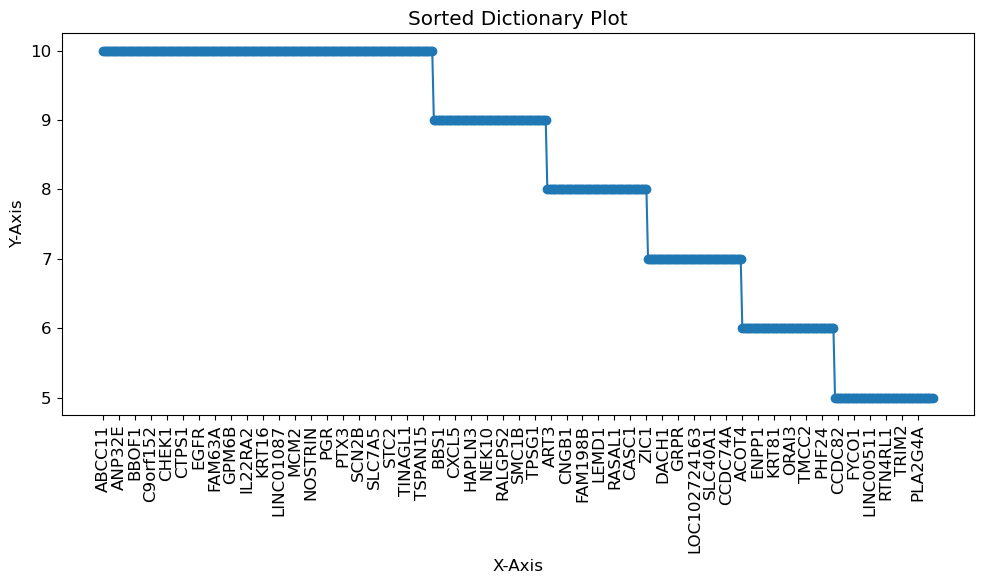

In [105]:
# Extract keys and values from the dictionary
keys = list(sorted_dict.keys())
values = list(sorted_dict.values())

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(keys, values, marker='o')

# Set x-axis ticks every 20th key
xticks = keys[::10]
plt.xticks(xticks, rotation=90)

# Adding labels and title
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.title('Sorted Dictionary Plot')

# Show the plot
plt.tight_layout()

In [107]:
sorted_dict.keys()

dict_keys(['ABCC11', 'ACADSB', 'ACBD4', 'ACE2', 'ACOX2', 'ADCY9', 'AFF3', 'AGR2', 'ANKRD30A', 'ANLN', 'ANP32E', 'ANXA8', 'ANXA9', 'APH1B', 'AR', 'ARHGEF38', 'ARMT1', 'ARSG', 'AURKA', 'B3GNT5', 'BBOF1', 'BBOX1', 'BCAS1', 'BCL11A', 'BCL2', 'BLM', 'BTG2', 'C10orf90', 'C1orf64', 'C6orf15', 'C9orf152', 'CA12', 'CACNA2D2', 'CCNE1', 'CCNE2', 'CDC25B', 'CDC7', 'CDCA7', 'CENPN', 'CENPW', 'CHEK1', 'CHST2', 'CHST3', 'CIB3', 'CKS1B', 'CMBL', 'CNTNAP3', 'CPLX1', 'CRYAB', 'CT62', 'CTPS1', 'CX3CL1', 'CXCL1', 'CXXC5', 'DBF4', 'DEGS2', 'DMD', 'DNMT3B', 'DSCC1', 'DUSP7', 'EGFR', 'EPHB6', 'ERBB2', 'ERBB3', 'ERBB4', 'EZH2', 'FABP7', 'FAM120AOS', 'FAM134C', 'FAM171A1', 'FAM63A', 'FBXO5', 'FERMT1', 'FGD3', 'FSIP1', 'FZD9', 'GABRP', 'GALNT10', 'GARS', 'GDF5', 'GPM6B', 'GREB1', 'GTPBP4', 'HID1', 'HRCT1', 'ID4', 'IFNAR2', 'IGF1R', 'IGFBP4', 'IL1RL2', 'IL22RA2', 'IL34', 'IL6ST', 'ITFG2', 'JADE2', 'KCNJ11', 'KCNK15', 'KCNS1', 'KDM4B', 'KLK5', 'KRT16', 'KRT79', 'LAMP5', 'LBR', 'LDHB', 'LINC00092', 'LINC00839', 'L

In [108]:
from sklearn.feature_selection import SelectKBest, f_classif

# Initialize SelectKBest with the desired number of features and ANOVA F-test
num_features_to_select = 500
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)

# Fit and transform the selector on the data
X_selected = selector.fit_transform(X_train_scaled, y_train)

# Get selected feature indices
selected_feature_indices = selector.get_support(indices=True)
X_train_selected_kbest = X_train_scaled.loc[:, X_train_scaled.columns[selected_feature_indices]]
X_train_selected_kbest

,A2ML1,ABAT,ABCA13,ABCC8,ABLIM3,ACADSB,ACE2,ACOT4,ADAMTS15,ADCY9,...,YEATS2,ZBTB42,ZG16B,ZIC1,ZNF442,ZNF454,ZNF467,ZNF552,ZNF670-ZNF695,ZNF703
225,-2.050456,6.235758,-2.096476,3.980527,4.995204,5.376071,-2.354501,3.012050,6.172495,5.858090,...,5.980663,5.962754,6.708389,-2.858359,1.836639,-0.629313,5.229189,6.814213,1.499188,8.024337
598,-0.982464,5.620867,-2.997826,4.942180,6.302771,7.186747,-2.675091,0.052735,7.678085,4.710251,...,5.481599,4.897814,6.240276,-2.511025,1.925957,-0.538480,4.787756,3.240962,-1.177447,7.166321
405,-1.173796,6.408448,-2.030408,2.043535,4.430176,7.409356,-3.321928,3.156489,5.326709,5.366564,...,4.074940,4.822633,5.715708,-2.982164,2.639409,-0.743737,0.567388,6.617840,0.317623,3.042350
265,5.918910,2.483358,-1.928260,-2.771039,2.041034,3.629003,2.433315,2.008559,2.161911,3.262152,...,6.855508,2.628410,0.842019,3.893306,0.172393,0.584815,2.749217,2.976227,2.984769,4.707676
955,0.811845,3.572643,-3.304834,3.368940,3.588720,5.959206,-1.405241,3.212285,5.392555,5.866222,...,4.785684,5.623630,8.091979,-3.037464,2.299435,-1.514697,5.740348,4.443134,-1.728427,6.462758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,-2.873832,6.699458,-2.371754,2.136522,5.459071,8.808552,-2.387906,5.087145,8.401577,6.475075,...,5.433601,5.757703,6.701096,-1.028154,1.448432,0.102580,3.267384,7.136506,-0.322813,7.423128
765,-2.262172,6.738774,-2.819798,2.371607,5.931625,6.135081,-2.596895,5.004034,8.238364,6.360193,...,5.320877,5.622008,6.986466,-3.036104,2.370935,-2.415625,3.995264,5.715511,1.385551,7.984382
137,-0.456085,4.622806,-0.191239,5.222662,5.039976,4.997043,-1.265866,2.971360,7.698192,5.224982,...,5.411524,4.644113,4.951847,-2.753218,1.672119,-0.201089,4.082683,4.967788,0.663333,7.427151
244,5.123030,3.660404,0.089408,-2.976719,4.731199,4.621584,-1.716893,2.508091,4.069265,4.471716,...,5.841018,2.592597,-0.047957,1.201206,2.101116,1.094685,2.565383,3.006979,1.629583,3.689363


In [113]:
same_feat = set(X_train_selected_kbest.columns).intersection(set(sorted_dict.keys()))

In [114]:
# Given set of keys to include
keys_to_include = list(same_feat)

# Create a new dictionary with only the selected keys
new_dict = {key: sorted_dict[key] for key in keys_to_include if key in sorted_dict}
new_dict

{'CTSV': 8,
 'CASC8': 6,
 'SUOX': 10,
 'MPP6': 5,
 'BBS1': 9,
 'RARRES1': 10,
 'KCNN4': 7,
 'SYTL5': 7,
 'CDH3': 9,
 'ERGIC1': 6,
 'CDCA7': 10,
 'CT62': 10,
 'ATP8B1': 6,
 'FERMT1': 10,
 'NEK10': 9,
 'LINC01117': 10,
 'SMOC1': 5,
 'CERS6': 8,
 'LINC00092': 10,
 'IGFBP4': 10,
 'SLC7A5': 10,
 'CACNA2D2': 10,
 'ZIC1': 8,
 'RGS22': 10,
 'LRRC46': 6,
 'IL6ST': 10,
 'ACADSB': 10,
 'CELSR1': 5,
 'LRRC17': 9,
 'KCMF1': 6,
 'KCNJ11': 10,
 'CKS1B': 10,
 'PI3': 9,
 'SRSF12': 10,
 'STAC': 10,
 'HID1': 10,
 'FAM214A': 8,
 'GREB1': 10,
 'HRCT1': 10,
 'LOC101927934': 5,
 'LBR': 10,
 'CXXC5': 10,
 'LANCL3': 6,
 'INPP5J': 9,
 'CFAP69': 8,
 'MTHFD1L': 9,
 'KCNS1': 10,
 'STARD10': 6,
 'NUDT12': 6,
 'POU5F1': 8,
 'LINC01016': 10,
 'SPTBN4': 5,
 'CLSTN2': 7,
 'CHST2': 10,
 'C11orf91': 8,
 'SCUBE2': 10,
 'PADI2': 9,
 'BBOX1': 10,
 'ERBB4': 10,
 'MAPK4': 10,
 'GALNT7': 8,
 'CHAD': 8,
 'TRIM3': 10,
 'LONRF2': 5,
 'NT5DC2': 7,
 'DNAJC12': 8,
 'ANKRD30A': 10,
 'NME5': 7,
 'FZD9': 10,
 'JADE2': 10,
 'KCNK15': 10

In [115]:
new_sorted_dict = {k: v for k, v in sorted(new_dict.items(), key=lambda item: item[1], reverse=True)}
new_sorted_dict

{'SUOX': 10,
 'RARRES1': 10,
 'CDCA7': 10,
 'CT62': 10,
 'FERMT1': 10,
 'LINC01117': 10,
 'LINC00092': 10,
 'IGFBP4': 10,
 'SLC7A5': 10,
 'CACNA2D2': 10,
 'RGS22': 10,
 'IL6ST': 10,
 'ACADSB': 10,
 'KCNJ11': 10,
 'CKS1B': 10,
 'SRSF12': 10,
 'STAC': 10,
 'HID1': 10,
 'GREB1': 10,
 'HRCT1': 10,
 'LBR': 10,
 'CXXC5': 10,
 'KCNS1': 10,
 'LINC01016': 10,
 'CHST2': 10,
 'SCUBE2': 10,
 'BBOX1': 10,
 'ERBB4': 10,
 'MAPK4': 10,
 'TRIM3': 10,
 'ANKRD30A': 10,
 'FZD9': 10,
 'JADE2': 10,
 'KCNK15': 10,
 'LOC105375624': 10,
 'PGPEP1': 10,
 'DEGS2': 10,
 'TCEAL1': 10,
 'RERG': 10,
 'SCCPDH': 10,
 'CA12': 10,
 'CENPN': 10,
 'ANLN': 10,
 'STMN1': 10,
 'SLC16A6': 10,
 'LOC102723854': 10,
 'GDF5': 10,
 'BCAS1': 10,
 'SERPINB5': 10,
 'KRT16': 10,
 'PHGDH': 10,
 'PDSS1': 10,
 'GPM6B': 10,
 'KDM4B': 10,
 'LDHB': 10,
 'FSIP1': 10,
 'CHEK1': 10,
 'NEK5': 10,
 'SLC7A8': 10,
 'AR': 10,
 'ADCY9': 10,
 'PARD6B': 10,
 'TSPAN15': 10,
 'OCA2': 10,
 'SLC6A2': 10,
 'NXNL2': 10,
 'CENPW': 10,
 'EGFR': 10,
 'AURKA': 1

In [117]:
with open('../data/feat_select_gt_50_perc_occur.pkl', 'wb') as file:
    pickle.dump(list(sorted_dict.keys()), file)

In [82]:
# Initialize SelectKBest with the desired number of features and ANOVA F-test
num_features_to_select = 582
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)

# Fit and transform the selector on the data
X_selected = selector.fit_transform(X_train_scaled, y_train)

# Get selected feature indices
selected_feature_indices = selector.get_support(indices=True)
X_train_selected_kbest = X_train_scaled.loc[:, X_train_scaled.columns[selected_feature_indices]]
len(set(X_train_selected_kbest.columns).intersection(set(feat_fr_rfecv)))

387

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the model you want to use
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize SequentialFeatureSelector with the desired number of features
num_features_to_select_sfs = 1000
sfs = SequentialFeatureSelector(rf, n_features_to_select=num_features_to_select_sfs, direction='forward', cv=5)

best_val_performance = 0.0  # Initialize with a low value
stop_condition_met = False

# Iterate through feature selection steps
for i in range(400, num_features_to_select_sfs):
    # Fit SFS on the data
    sfs.fit(X_train_selected_kbest, y_train)
    
    # Get selected feature indices
    selected_feature_indices_sfs = sfs.get_support(indices=True)
    
    # Train the model using the selected features
    rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_selected.fit(X_train_selected_kbest[:, selected_feature_indices_sfs], y_train)
    
    # Predict on validation data
    y_pred_val = rf_selected.predict(X_val[:, selected_feature_indices_sfs])
    
    # Calculate validation accuracy
    val_accuracy = accuracy_score(y_val, y_pred_val)
    
    print(f"Iteration {i + 1}: Validation accuracy = {val_accuracy:.4f}")
    
    # Check if validation performance is declining
    if val_accuracy <= best_val_performance:
        print("Validation performance is declining. Stopping feature selection.")
        stop_condition_met = True
        break
    else:
        best_val_performance = val_accuracy

if not stop_condition_met:
    print("Feature selection completed without meeting the stopping criterion.")


In [ ]:
min_features_to_select = 400  # Minimum number of features to consider
clf = LogisticRegression(random_state=0, max_iter=1000)
cv = StratifiedKFold(5)

rfecv2 = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
    verbose=2
)
rfecv2.fit(X_train_selected_kbest, y_train)

In [84]:
feat_fr_rfecv2 = X_train_selected_kbest.loc[:, rfecv2.support_].columns
len(feat_fr_rfecv2)

449

Text(0.5, 1.0, 'Recursive Feature Elimination \nwith correlated features')

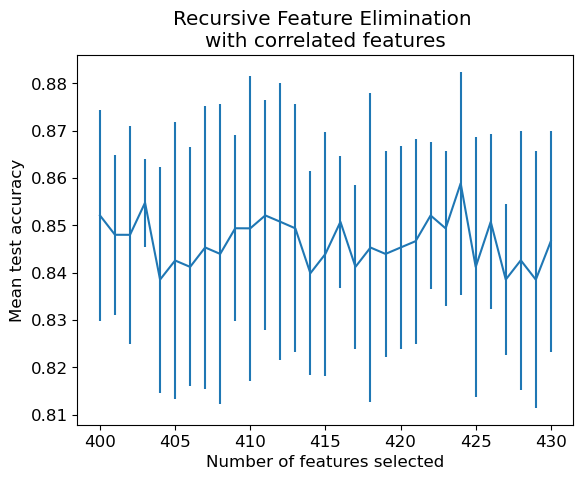

In [74]:
n_scores = len(rfecv.cv_results_["mean_test_score"][::20])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"][::20],
    yerr=rfecv.cv_results_["std_test_score"][::20],
)
plt.title("Recursive Feature Elimination \nwith correlated features")

In [14]:
from sklearn.feature_selection import SelectFromModel, SelectKBest, RFE, f_classif, chi2, f_regression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LassoCV

# ----------- LASSO ------------
#  
# Initialize the LassoCV model with cross-validation
lasso_cv = LassoCV(n_alphas=1000, eps=0.0001, cv=5, max_iter=3000, tol=0.0001, verbose=2, random_state=4, selection='random')

# Fit the LassoCV model on the training data
lasso_cv.fit(X_train_scaled, y_train)

# Selected features (coefficients that are not zero)
selected_features = np.where(lasso_cv.coef_ != 0)[0]

# Print selected features
print("Selected features:", selected_features)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Path: 000 out of 1000
Path: 001 out of 1000
Path: 002 out of 1000
Path: 003 out of 1000
Path: 004 out of 1000
Path: 005 out of 1000
Path: 006 out of 1000
Path: 007 out of 1000
Path: 008 out of 1000
Path: 009 out of 1000
Path: 010 out of 1000
Path: 011 out of 1000
Path: 012 out of 1000
Path: 013 out of 1000
Path: 014 out of 1000
Path: 015 out of 1000
Path: 016 out of 1000
Path: 017 out of 1000
Path: 018 out of 1000
Path: 019 out of 1000
Path: 020 out of 1000
Path: 021 out of 1000
Path: 022 out of 1000
Path: 023 out of 1000
Path: 024 out of 1000
Path: 025 out of 1000
Path: 026 out of 1000
Path: 027 out of 1000
Path: 028 out of 1000
Path: 029 out of 1000
Path: 030 out of 1000
Path: 031 out of 1000
Path: 032 out of 1000
Path: 033 out of 1000
Path: 034 out of 1000
Path: 035 out of 1000
Path: 036 out of 1000
Path: 037 out of 1000
Path: 038 out of 1000
Path: 039 out of 1000
Path: 040 out of 1000
Path: 041 out of 1000
Path: 042 out of 1000
Path: 043 out of 1000
Path: 044 out of 1000
Path: 045 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.8min remaining:    0.0s


Path: 000 out of 1000
Path: 001 out of 1000
Path: 002 out of 1000
Path: 003 out of 1000
Path: 004 out of 1000
Path: 005 out of 1000
Path: 006 out of 1000
Path: 007 out of 1000
Path: 008 out of 1000
Path: 009 out of 1000
Path: 010 out of 1000
Path: 011 out of 1000
Path: 012 out of 1000
Path: 013 out of 1000
Path: 014 out of 1000
Path: 015 out of 1000
Path: 016 out of 1000
Path: 017 out of 1000
Path: 018 out of 1000
Path: 019 out of 1000
Path: 020 out of 1000
Path: 021 out of 1000
Path: 022 out of 1000
Path: 023 out of 1000
Path: 024 out of 1000
Path: 025 out of 1000
Path: 026 out of 1000
Path: 027 out of 1000
Path: 028 out of 1000
Path: 029 out of 1000
Path: 030 out of 1000
Path: 031 out of 1000
Path: 032 out of 1000
Path: 033 out of 1000
Path: 034 out of 1000
Path: 035 out of 1000
Path: 036 out of 1000
Path: 037 out of 1000
Path: 038 out of 1000
Path: 039 out of 1000
Path: 040 out of 1000
Path: 041 out of 1000
Path: 042 out of 1000
Path: 043 out of 1000
Path: 044 out of 1000
Path: 045 

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 30.8min finished


Selected features: [    5    26   231   415   429   481   482   567   637   638   671   720
   852   934   935  1686  1980  2309  2361  2385  2467  2525  2692  2810
  3170  3192  3308  3595  3650  3831  3945  3969  3975  3997  4111  4113
  4192  4216  4226  4484  4568  4614  4622  4736  4921  5031  5039  5326
  5327  5328  5362  5412  5432  5706  5712  5822  5854  6120  6285  6384
  6578  6749  6801  6826  6859  6958  7096  7116  7135  7208  7384  7667
  7732  7779  7784  8404  8413  8490  8935  8969  9618  9690 10126 10502
 11291 11528 11957 12557 12758 12796 13075 13166 13280 13601 13730 13759
 13813 13866 14028 14698 14749 15037 15269 15597 15684 15745 15902 15927
 16165 16247 16410 16417 17250 17418 17445 17447 17631 17632 17653 17844
 17959 18260 18440 18967 19228 19310 19433 20074 20615 21228 21449 21504
 21577 21724 21974 22046 22080]


In [16]:
len(selected_features)

137

In [18]:
# ----------- LASSO ------------
#  
# Initialize the LassoCV model with cross-validation
lasso_cv = LassoCV(n_alphas=500, eps=0.0001, cv=5, max_iter=3000, tol=0.0001, verbose=2, random_state=4, selection='cyclic')

# Fit the LassoCV model on the training data
lasso_cv.fit(X_train_scaled, y_train)

# Selected features (coefficients that are not zero)
selected_features = np.where(lasso_cv.coef_ != 0)[0]

# Print selected features
print("Selected features:", selected_features)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Path: 000 out of 500
Path: 001 out of 500
Path: 002 out of 500
Path: 003 out of 500
Path: 004 out of 500
Path: 005 out of 500
Path: 006 out of 500
Path: 007 out of 500
Path: 008 out of 500
Path: 009 out of 500
Path: 010 out of 500
Path: 011 out of 500
Path: 012 out of 500
Path: 013 out of 500
Path: 014 out of 500
Path: 015 out of 500
Path: 016 out of 500
Path: 017 out of 500
Path: 018 out of 500
Path: 019 out of 500
Path: 020 out of 500
Path: 021 out of 500
Path: 022 out of 500
Path: 023 out of 500
Path: 024 out of 500
Path: 025 out of 500
Path: 026 out of 500
Path: 027 out of 500
Path: 028 out of 500
Path: 029 out of 500
Path: 030 out of 500
Path: 031 out of 500
Path: 032 out of 500
Path: 033 out of 500
Path: 034 out of 500
Path: 035 out of 500
Path: 036 out of 500
Path: 037 out of 500
Path: 038 out of 500
Path: 039 out of 500
Path: 040 out of 500
Path: 041 out of 500
Path: 042 out of 500
Path: 043 out of 500
Path: 044 out of 500
Path: 045 out of 500
Path: 046 out of 500
Path: 047 out

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.5min remaining:    0.0s


Path: 000 out of 500
Path: 001 out of 500
Path: 002 out of 500
Path: 003 out of 500
Path: 004 out of 500
Path: 005 out of 500
Path: 006 out of 500
Path: 007 out of 500
Path: 008 out of 500
Path: 009 out of 500
Path: 010 out of 500
Path: 011 out of 500
Path: 012 out of 500
Path: 013 out of 500
Path: 014 out of 500
Path: 015 out of 500
Path: 016 out of 500
Path: 017 out of 500
Path: 018 out of 500
Path: 019 out of 500
Path: 020 out of 500
Path: 021 out of 500
Path: 022 out of 500
Path: 023 out of 500
Path: 024 out of 500
Path: 025 out of 500
Path: 026 out of 500
Path: 027 out of 500
Path: 028 out of 500
Path: 029 out of 500
Path: 030 out of 500
Path: 031 out of 500
Path: 032 out of 500
Path: 033 out of 500
Path: 034 out of 500
Path: 035 out of 500
Path: 036 out of 500
Path: 037 out of 500
Path: 038 out of 500
Path: 039 out of 500
Path: 040 out of 500
Path: 041 out of 500
Path: 042 out of 500
Path: 043 out of 500
Path: 044 out of 500
Path: 045 out of 500
Path: 046 out of 500
Path: 047 out

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 34.7min finished


Selected features: [    5    26   231   415   429   481   482   567   637   638   671   720
   852   934   935  1686  1980  2309  2361  2385  2467  2525  2692  2810
  3170  3192  3308  3595  3650  3831  3945  3969  3975  3997  4111  4113
  4192  4216  4226  4484  4568  4614  4622  4736  4921  5031  5039  5326
  5327  5328  5362  5412  5432  5706  5712  5822  5854  6120  6285  6384
  6578  6749  6801  6826  6859  6958  7096  7116  7135  7208  7384  7667
  7732  7779  7784  8404  8413  8490  8935  8969  9618  9690 10126 10502
 11291 11528 11957 12557 12758 12796 13075 13166 13280 13601 13730 13759
 13813 13866 14028 14698 14749 15037 15269 15597 15684 15745 15902 15927
 16165 16247 16410 16417 17250 17418 17445 17447 17631 17632 17653 17844
 17959 18260 18440 18967 19082 19228 19310 19433 19497 20074 20615 21228
 21449 21504 21577 21724 21974 22046 22080]


In [19]:
lasso_feat_1000 = [5, 26, 231, 415,   429,   481,   482,   567,   637,   638,   671,   720,
   852,   934,   935,  1686,  1980,  2309,  2361,  2385,  2467,  2525,  2692,  2810,
  3170,  3192,  3308,  3595,  3650,  3831,  3945,  3969,  3975,  3997,  4111,  4113,
  4192,  4216,  4226,  4484,  4568,  4614,  4622,  4736,  4921,  5031,  5039,  5326,
  5327,  5328,  5362,  5412, 5432,  5706,  5712,  5822,  5854,  6120,  6285,  6384,
  6578,  6749,  6801,  6826,  6859,  6958,  7096,  7116,  7135,  7208,  7384,  7667,
  7732,  7779,  7784,  8404,  8413,  8490,  8935,  8969,  9618,  9690, 10126, 10502,
 11291, 11528, 11957, 12557, 12758, 12796, 13075, 13166, 13280, 13601, 13730, 13759,
 13813, 13866, 14028, 14698, 14749, 15037, 15269, 15597, 15684, 15745, 15902, 15927,
 16165, 16247, 16410, 16417, 17250, 17418, 17445, 17447, 17631, 17632, 17653, 17844,
 17959, 18260, 18440, 18967, 19228, 19310, 19433 ,20074 ,20615 ,21228, 21449, 21504,
 21577, 21724, 21974, 22046, 22080]
lasso_feat_500 = selected_features

In [24]:
print("LASSO with 1000: ", len(lasso_feat_1000))
print("LASSO with 500: ", len(lasso_feat_500))
len(set(lasso_feat_1000).intersection(set(lasso_feat_500)))

LASSO with 1000:  137
LASSO with 500:  139


137

In [ ]:
# Initialize the LassoCV model with cross-validation
lasso_cv = LassoCV(alphas=np.linspace(0.01, 1.0, 10), eps=0.0001, cv=5, max_iter=3000, tol=0.0001, verbose=1, random_state=4, selection='cyclic')

# Fit the LassoCV model on the training data
lasso_cv.fit(X_train_scaled, y_train)

# Specify the desired number of features
desired_num_features = 1000

# Get selected features (coefficients that are not zero)
selected_feature_indices = np.where(lasso_cv.coef_ != 0)[0]
clear_output(wait=True)

In [32]:
# If the number of selected features is less than the desired number,
# we can increase the alpha value and re-fit the model
while len(selected_feature_indices) < desired_num_features:
    lasso_cv.alpha_ *= 2  # Increase alpha to get more features
    print("Alpha increase to ", lasso_cv.alpha_)
    lasso_cv.fit(X_train_scaled, y_train)
    selected_feature_indices = np.where(lasso_cv.coef_ != 0)[0]
    print("Number of selected: ", len(selected_feature_indices))

# Select the top N features based on their coefficients
top_n_indices = selected_feature_indices[np.argsort(np.abs(lasso_cv.coef_[selected_feature_indices]))[-desired_num_features:]]

Alpha increase to  0.20581818181818184


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Path: 000 out of 100
Path: 001 out of 100
Path: 002 out of 100
Path: 003 out of 100
Path: 004 out of 100
Path: 005 out of 100
Path: 006 out of 100
Path: 007 out of 100
Path: 008 out of 100
Path: 009 out of 100
Path: 010 out of 100
Path: 011 out of 100
Path: 012 out of 100
Path: 013 out of 100
Path: 014 out of 100
Path: 015 out of 100
Path: 016 out of 100
Path: 017 out of 100
Path: 018 out of 100
Path: 019 out of 100
Path: 020 out of 100
Path: 021 out of 100
Path: 022 out of 100
Path: 023 out of 100
Path: 024 out of 100
Path: 025 out of 100
Path: 026 out of 100
Path: 027 out of 100
Path: 028 out of 100
Path: 029 out of 100
Path: 030 out of 100
Path: 031 out of 100
Path: 032 out of 100
Path: 033 out of 100
Path: 034 out of 100
Path: 035 out of 100
Path: 036 out of 100
Path: 037 out of 100
Path: 038 out of 100
Path: 039 out of 100
Path: 040 out of 100
Path: 041 out of 100
Path: 042 out of 100
Path: 043 out of 100
Path: 044 out of 100
Path: 045 out of 100
Path: 046 out of 100
Path: 047 out

KeyboardInterrupt: 

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize Sequential Feature Selector
sfs = SequentialFeatureSelector(rf, n_features_to_select=100, direction='forward', cv=5)

# Fit SFS on training data
sfs.fit(X_train_scaled, y_train)

# Get selected feature indices
selected_feature_indices = sfs.get_support(indices=True)

print("Selected feature indices:", selected_feature_indices)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import stability_selection

# Initialize Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform stability selection
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
selector = stability_selection.StabilitySelection(base_estimator=rf, cv=cv)
selector.fit(X, y)

# Get selected feature indices
selected_feature_indices = np.where(selector.get_support())[0]

print("Selected feature indices:", selected_feature_indices)


In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector, SelectFwe
from sklearn.model_selection import StratifiedKFold
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Initialize SelectKBest with the desired number of features and ANOVA F-test
num_features_to_select = 1000
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)

# Fit and transform the selector on the data
X_selected = selector.fit_transform(X_train_scaled, y_train)

# Get selected feature indices
selected_feature_indices = selector.get_support(indices=True)
X_train_selected_kbest = X_train_scaled.loc[:, X_train_scaled.columns[selected_feature_indices]]
X_train_selected_kbest

X_train_selected_kbest = X_train_scaled.loc[:, X_train_scaled.columns[selected_feature_indices]]

# Initialize the model you want to use
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize SequentialFeatureSelector with the desired number of features
num_features_to_select_sfs = 3
sfs = SFS(rf_selected, 
    k_features=num_features_to_select_sfs, 
    forward=True, 
    floating=False, 
    verbose=2,
    scoring='accuracy',
    cv=5)

sfs.fit(X_train_selected_kbest, y_train)

# Get selected feature indices
selected_feature_indices_sfs = sfs.get_support(indices=True)

# Initialize StratifiedKFold for cross-validation
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

best_val_performance = 0.0  # Initialize with a low value
stop_condition_met = False

# Iterate through feature selection steps
for i in range(1, num_features_to_select_sfs):
    val_accuracies = []

    # Perform cross-validation
    for train_index, val_index in skf.split(X_train_selected_kbest, y_train):
        X_train, X_val = X_train_selected_kbest.iloc[train_index, :], X_train_selected_kbest.iloc[val_index, :]
        y_train, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Fit SFS on the data
        sfs.fit(X_train, y_train)
    
        # Get selected feature indices
        selected_feature_indices_sfs = sfs.get_support(indices=True)
    
        # Train the model using the selected features
        rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_selected.fit(X_train[:, selected_feature_indices_sfs], y_train)

        # Predict on validation data
        y_pred_val = rf_selected.predict(X_val[:, selected_feature_indices_sfs])
    
        # Calculate validation accuracy
        val_accuracy = accuracy_score(y_val, y_pred_val)
        val_accuracies.append(val_accuracy)
    
    avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)
    
    print(f"Iteration {i + 1}: Average validation accuracy = {avg_val_accuracy:.4f}")
    
    # Check if validation performance is declining
    if avg_val_accuracy <= best_val_performance:
        print("Validation performance is declining. Stopping feature selection.")
        stop_condition_met = True
        break
    else:
        best_val_performance = avg_val_accuracy

if not stop_condition_met:
    print("Feature selection completed without meeting the stopping criterion.")
    
   


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  9.8min finished

[2023-08-25 18:01:27] Features: 1/3 -- score: 0.6228534657106086[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 999 out of 999 | elapsed:  9.6min finished

[2023-08-25 18:11:05] Features: 2/3 -- score: 0.6391799963228534[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 998 out of 998 | elapsed:  9.5min finished

[2023-08-25 18:20:34] Features: 3/3 -- score: 0.641790770362199

AttributeError: 'SequentialFeatureSelector' object has no attribute 'get_support'

In [50]:
len(selected_feature_indices_sfs)

999

In [51]:
# Initialize SequentialFeatureSelector with the desired number of features
num_features_to_select_sfs = 100
sfs2 = SequentialFeatureSelector(rf_selected, n_features_to_select='auto', tol=0.001, direction='backward', cv=5, scoring='accuracy')

sfs2.fit(X_train_selected_kbest, y_train)

# Get selected feature indices
selected_feature_indices_sfs_2 = sfs2.get_support(indices=True)

# step backward feature elimination
sfs1 = SFS(RandomForestRegressor(), 
           k_features=10, 
           forward=False, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=3)

sfs1 = sfs1.fit(np.array(X_train), y_train)

KeyboardInterrupt: 

In [24]:
y_train

225    3
598    2
405    2
265    0
955    2
      ..
966    2
765    3
137    2
244    0
691    2
Length: 737, dtype: int64

In [62]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X = X_train_selected_kbest
y = y_train

# Initialize the model you want to use
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize StratifiedKFold for cross-validation
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Get initial accuracy with all features
initial_accuracy = []
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index, :], X.iloc[val_index, :]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Train the model on all features
    rf.fit(X_train, y_train)
    
    # Predict on validation data
    y_pred_val = rf.predict(X_val)
    
    # Calculate validation accuracy
    val_accuracy = accuracy_score(y_val, y_pred_val)
    initial_accuracy.append(val_accuracy)

# Get the initial average validation accuracy
best_val_performance = np.mean(initial_accuracy)
print("Initial average validation accuracy:", best_val_performance)

# Start feature elimination
selected_feature_indices = np.arange(X.shape[1])
stop_condition_met = False

while not stop_condition_met:
    # Track whether any features were removed in this iteration
    feature_removed = False
    
    # Initialize the best accuracy for this iteration
    best_iteration_accuracy = 0.0
    
    for feature_index in selected_feature_indices:
        # Temporarily remove the feature
        reduced_X = X.drop(X.columns[feature_index], axis=1)
        
        # Initialize a list to store validation accuracies
        val_accuracies = []
        
        # Perform cross-validation
        for train_index, val_index in skf.split(reduced_X, y):
            X_train, X_val = reduced_X.iloc[train_index, :], reduced_X.iloc[val_index, :]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]
            
            # Train the model on reduced features
            rf.fit(X_train, y_train)
            
            # Predict on validation data
            y_pred_val = rf.predict(X_val)
            
            # Calculate validation accuracy
            val_accuracy = accuracy_score(y_val, y_pred_val)
            val_accuracies.append(val_accuracy)
        
        # Get the average validation accuracy for this feature
        avg_val_accuracy = np.mean(val_accuracies)
        
        # Check if removing this feature improves accuracy
        if avg_val_accuracy > best_iteration_accuracy:
            best_iteration_accuracy = avg_val_accuracy
            feature_to_remove = feature_index
            feature_removed = True
    
    # Check if any feature was removed
    if feature_removed:
        selected_feature_indices = np.delete(selected_feature_indices, feature_to_remove)
        
        # Update the best validation accuracy if improved
        if best_iteration_accuracy > best_val_performance:
            best_val_performance = best_iteration_accuracy
            print("Removed feature index:", feature_to_remove)
            print("New best validation accuracy:", best_val_performance)
    else:
        stop_condition_met = True

print("Feature elimination completed.")
print("Selected feature indices:", selected_feature_indices)


Initial average validation accuracy: 0.8412667769810627
Removed feature index: 935
New best validation accuracy: 0.8521235521235522


KeyboardInterrupt: 